In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline
import pyccl as ccl  # Python Core Cosmology Library
from astropy import cosmology
from colossus.cosmology import cosmology as colcosmology

import emcee
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
cosmo = cosmology.Planck18

In [4]:
cclcosmo = ccl.Cosmology(Omega_c=cosmo.Odm0, Omega_b=cosmo.Ob0, h=cosmo.h,
    n_s=0.965, sigma8=0.81, Neff=cosmo.Neff, Omega_g=cosmo.Ogamma0)

In [5]:
colcosmo = colcosmology.setCosmology('planck18')

In [6]:
def calculate_wp(cosmo, rp, z, pimax, dpi=1):
    rmax = np.sqrt(rp[-1]**2 + pimax**2)*1.1
    rmin = rp[0]

    Npi = int(pimax / dpi)

    Nbin = (Npi + len(rp))*10

    r = np.geomspace(rmin, rmax, Nbin)
    r_ccl = r / cosmo['h']  # Mpc

    xi = ccl.correlation_3d(cosmo, a=1./(1+z), r=r_ccl, p_of_k_a='delta_matter:delta_matter')
    # xi = ccl.correlation_3d(cosmo, a=1./(1+z), r=r_ccl, p_of_k_a=cosmo.get_nonlin_power())
            # ccl cosmology uses Mpc
    xi_interp = InterpolatedUnivariateSpline(r, xi)

    # Integration along the line-of-sight direction
    pi_values = np.linspace(0, pimax-dpi, Npi) + dpi/2 #make symetric pi bins
    
    wp = np.zeros_like(rp, dtype=float)
    for i, rp_i in enumerate(rp):
        for pi_j in pi_values:
            # Calculate r^2 = rp^2 + pi^2
            r_val = np.sqrt(rp_i**2 + pi_j**2)
            
            # Skip if r is outside interpolation range
            if r_val < r[0] or r_val > r[-1]:
                print(1)
                continue
            # Add to the integral
            wp[i] += 2 * xi_interp(r_val) * dpi
    return wp

def calculate_wp2(cosmo, rp, z, pimax, dpi=1):
    rmax = np.sqrt(rp[-1]**2 + pimax**2)*1.1
    rmin = rp[0]

    Npi = int(pimax / dpi)

    Nbin = (Npi + len(rp))*10

    r = np.geomspace(rmin, rmax, Nbin)

    xi = cosmo.correlationFunction(r, z)            # col cosmology uses cMpc/h
    xi_interp = InterpolatedUnivariateSpline(r, xi)
    
    # Integration along the line-of-sight direction
    pi_values = np.linspace(0, pimax-dpi, Npi) + dpi/2 #make symetric pi bins
    
    wp = np.zeros_like(rp, dtype=float)
    for i, rp_i in enumerate(rp):
        for pi_j in pi_values:
            # Calculate r^2 = rp^2 + pi^2
            r_val = np.sqrt(rp_i**2 + pi_j**2)
            
            # Skip if r is outside interpolation range
            if r_val < r[0] or r_val > r[-1]:
                print(1)
                continue
            # Add to the integral
            wp[i] += 2 * xi_interp(r_val) * dpi
    return wp

In [7]:
def read_signal(file):
    ret_ls = []
    with open(file, 'rb') as f:
        while True:
            try: ret_ls.append(np.load(f))
            except EOFError:
                break
    return ret_ls

In [35]:
signal_path = 'signal_z3'
catalogue_path = '/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/catalogue/quasar_lss_z3.npy'

In [36]:
rp_auto, signal_auto, rp_cross, signal_cross = read_signal(f'{signal_path}/signal.npy')
cov = np.load(f'{signal_path}/cov.npy')
auto_range = (10, 20)
cross_range = (0, 13)
l_a, r_a = auto_range[0], auto_range[1]
l_c, r_c = cross_range[0], cross_range[1]

auto_size = len(rp_auto)
cross_size = len(rp_cross)
rp_auto = rp_auto[l_a:r_a]
rp_cross = rp_cross[l_c:r_c]
signal_auto = signal_auto[l_a:r_a]
signal_cross = signal_cross[l_c:r_c]

Cmm = cov[l_c:r_c, l_c:r_c]
Cqq = cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a]

z = np.load(catalogue_path)['z'].mean()

In [37]:
wp_a = calculate_wp2(colcosmo, rp_auto, z, 100, 1)      # use colossus linear power spectrum.
wp_c = calculate_wp2(colcosmo, rp_cross, z, 100, 1)

# auto correlation

In [38]:
cov_inv = np.linalg.inv(Cqq)
def lnprob(b):
    delta = signal_auto - b*b*wp_a
    return -(delta.reshape((1, -1))@cov_inv@delta.reshape((-1, 1))).flatten()[0]
p0 = np.random.uniform(1, 3, 40).reshape((-1, 1))
sampler = emcee.EnsembleSampler(40, 1, lnprob)
sampler.run_mcmc(p0, 2000)
chain = sampler.get_chain(discard=500, flat = True)
res = np.percentile(chain, [50-34.1, 50, 50+34.1])
print('{:.5f},{:.5f},{:.5f}'.format(res[1], res[1]-res[0], res[2]-res[1]))

2.96309,0.04675,0.04579


# cross correlation

In [39]:
cov_inv = np.linalg.inv(Cmm)
def lnprob(b):
    delta = signal_cross - b*wp_c
    return -(delta.reshape((1, -1))@cov_inv@delta.reshape((-1, 1))).flatten()[0]
p0 = np.random.uniform(1, 3, 40).reshape((-1, 1))
sampler = emcee.EnsembleSampler(40, 1, lnprob)
sampler.run_mcmc(p0, 2000)
chain = sampler.get_chain(discard=500, flat = True)
res = np.percentile(chain, [50-34.1, 50, 50+34.1])
print('{:.5f},{:.5f},{:.5f}'.format(res[1], res[1]-res[0], res[2]-res[1]))

3.05021,0.26026,0.26559


In [7]:
cclcosmo2 = ccl.Cosmology(Omega_c=cosmo.Ode0, Omega_b=cosmo.Om0, h=cosmo.h,
    n_s=0.965, sigma8=0.81, Neff=cosmo.Neff, Omega_g=cosmo.Ogamma0, transfer_function='eisenstein_hu')

[]

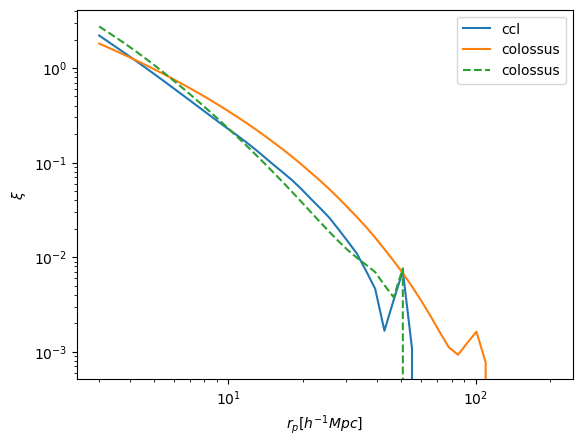

In [9]:
rp = np.geomspace(3, 200, 50)
z = 0
xi = ccl.correlation_3d(cclcosmo, a=1./(1+z), r=rp/cclcosmo['h'], p_of_k_a='delta_matter:delta_matter')
xi3 = ccl.correlation_3d(cclcosmo2, a=1./(1+z), r=rp/cclcosmo2['h'], p_of_k_a='delta_matter:delta_matter')
xi2 = colcosmo.correlationFunction(rp, z)
plt.plot(rp, xi, label='ccl')
plt.plot(rp, xi2, label='colossus')
plt.plot(rp, xi3, '--', label='colossus')
plt.xlabel(r'$r_p[h^{-1}Mpc$]')
plt.ylabel(r'$\xi$')
plt.legend()
plt.loglog()

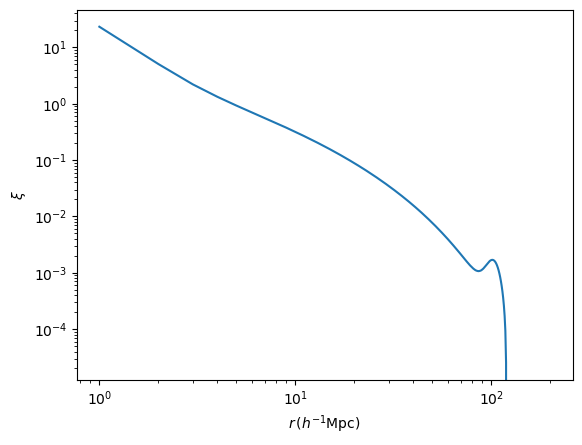

In [11]:
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.95, sigma8=0.8, transfer_function='eisenstein_hu')
r=np.linspace(1,200,200)# Mpc/h
a=1
xi=ccl.correlations.correlation_3d(cosmo, r=r/cosmo['h'], a=a, p_of_k_a='delta_matter:delta_matter')

plt.plot(r,xi)
plt.xlabel(r'$r\,(h^{-1}{\rm Mpc})$')
plt.ylabel(r'$\xi$')
plt.loglog()
plt.show()